# Задание 2
Имеются 2 технологические ёмкости, в которых происходит процесс перемешивания жидкостей. В каждой из них установлены следующие датчики:

- 1 датчик давления;

- 1 датчик расхода;

- 2 датчика уровня.

Задача: построить алгоритм предсказания нагрузки на смешивающий аппарат каждой ёмкости, используя показания датчиков, то есть нужно рассчитать нагрузку, используя остальные параметры. В итоге необходимо сравнить показания модели с реальной нагрузкой и посчитать ошибку. Даные во вложении (Таблица 'Данные для тестового задания 2.xlsx')

### Гипотеза:

1) Использование многослойной нейронной сети позволит минимизировать ошибку рассчетов;

2) Возможно использование акцивационных функций 'relu' и 'sigmoid' с учетом масштабирования признаков (включая обратное преобразование целевой переменной), т.н. обобщенная линейная модель.

#### Имплементация решения:
Язык программирования:
    
    - Python 3.6.3

Командная оболочка:
    
    - Jupyter Notebook | Anaconda custom (64-bit)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.set_printoptions(precision=6, linewidth=100)
from matplotlib import pyplot as plt
import pandas as pd

### Загрузка данных и препроцессинг

##### назначение выборки ('Аппарат перемешивания 1') в качестве тренировочного и тестового датасетов

In [3]:
df = pd.read_excel('Данные для тестового задания 2.xlsx', encoding = 'windows-1251').iloc[:,:5]
df.rename(columns={'Аппарат перемешивания 1': 'Нагрузка', 
                   'Unnamed: 1': 'Датчик_расхода',
                  'Unnamed: 2': 'Датчик_уровня_1', 
                  'Unnamed: 3': 'Датчик_уровня_2',
                  'Unnamed: 4': 'Датчик_давления'}, inplace=True)

In [4]:
df_original_labels = list(df.columns)
df.rename(columns={'Нагрузка': 'Capacity', 
                   'Датчик_расхода': 'Flow_Sensor',
                  'Датчик_уровня_1': 'Level_Sensor_1', 
                  'Датчик_уровня_2': 'Level_Sensor_2',
                  'Датчик_давления': 'Pressure_Meter'}, inplace=True)
df = df.drop([0]).reset_index(drop=True)

In [5]:
df[df.columns.tolist()] = df[df.columns.tolist()].astype(np.float64)

##### проверка основных статистик датасета

In [6]:
from pandas_summary import DataFrameSummary

In [7]:
display(DataFrameSummary(df).summary())

,Capacity,Flow_Sensor,Level_Sensor_1,Level_Sensor_2,Pressure_Meter
count,8411,8411,8411,8411,8411
mean,8.49296,10.1475,1067.54,1141.96,0.4917
std,0.153881,0.294863,50.6385,56.5413,0.0482176
min,7.98333,0,978.573,940.15,0.218033
25%,8.39667,9.93667,1046.85,1128.3,0.469683
50%,8.48,10.184,1054.27,1146.29,0.4976
75%,8.58,10.329,1078.84,1160.42,0.51835
max,11.3667,12.014,2508.46,2465.92,0.667067
counts,8411,8411,8411,8411,8411
uniques,897,5667,7581,7955,6425


In [8]:
df.head()

,Capacity,Flow_Sensor,Level_Sensor_1,Level_Sensor_2,Pressure_Meter
0,8.386667,10.021667,1047.853333,1150.563333,0.530767
1,8.426667,9.846000,1052.306667,1154.426667,0.533467
2,8.450000,9.846667,1047.516667,1155.223333,0.538733
3,8.470000,9.947333,1045.016667,1153.976667,0.549767
4,8.500000,9.860667,1060.140000,1165.850000,0.548033


##### Построение распределения признаков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000076B3428BA8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000076B2CB6DA0>]], dtype=object)

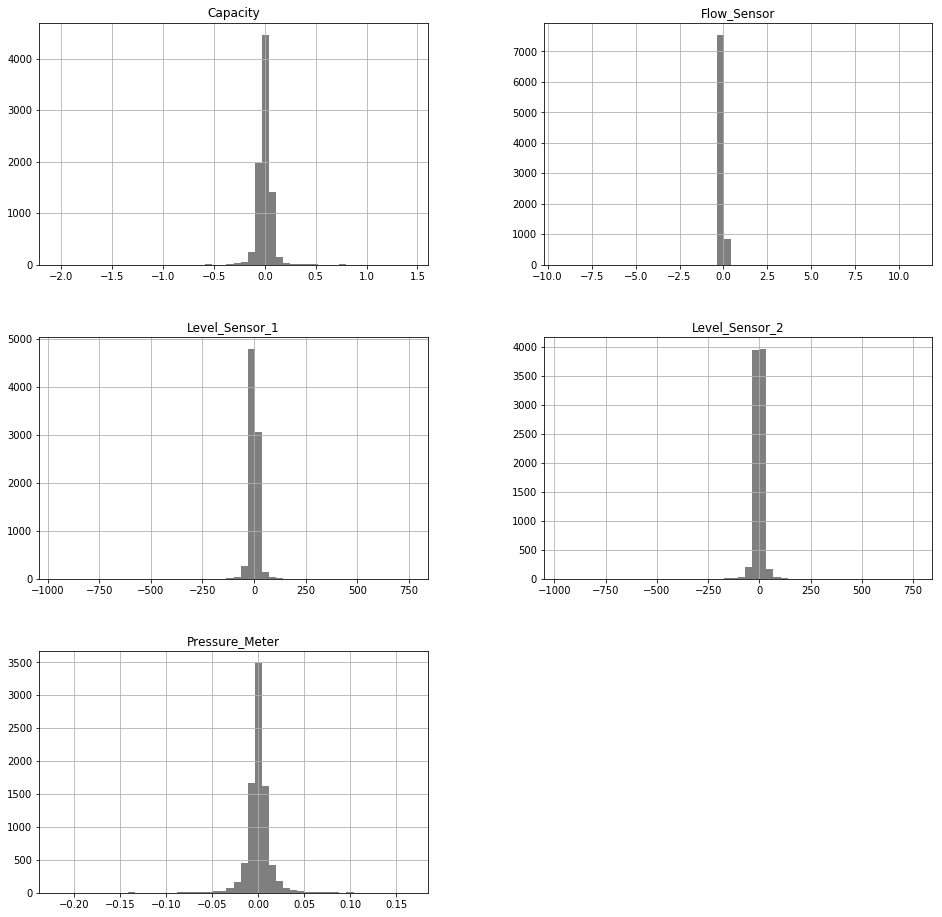

In [9]:
df.diff().hist(color='k', alpha=0.5, figsize=(16,16), bins=50)

#### Выделение тренировочной и тестовой выборок

Выделение поля 'Аппарат перемешивания 1: Нагрузка' в качестве целевой переменной

In [10]:
X = df.drop(df.columns[0], axis=1)
y = df.drop(df.columns[[1,2,3,4]], axis=1)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Масштабирование признаков

In [13]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

In [14]:
contin_vars = list(X_train.columns)
contin_maps = [([o], StandardScaler()) for o in contin_vars]
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(X_train)
contin_cols = len(contin_map_fit.features)

In [15]:
contin_map_fit.transform(X_train)

array([[ 5.748328e+00, -4.290221e-01, -1.048420e-01,  3.095705e+00],
       [-5.621132e-01, -3.542705e-01,  4.467934e-01,  3.179390e-02],
       [ 7.407481e-01,  7.920764e-02, -2.147494e+00, -1.880507e+00],
       ...,
       [ 5.075922e-01, -5.249387e-01, -1.267617e-01, -3.407057e-01],
       [-3.359871e-01, -2.932695e-01,  2.626561e-01,  6.082813e-01],
       [ 6.705636e-02,  1.304014e+00,  2.710776e-01,  1.093390e-03]])

In [16]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float64)

In [17]:
contin_map_X_train = contin_preproc(X_train)

In [18]:
contin_map_X_train

array([[ 5.748328e+00, -4.290221e-01, -1.048420e-01,  3.095705e+00],
       [-5.621132e-01, -3.542705e-01,  4.467934e-01,  3.179390e-02],
       [ 7.407481e-01,  7.920764e-02, -2.147494e+00, -1.880507e+00],
       ...,
       [ 5.075922e-01, -5.249387e-01, -1.267617e-01, -3.407057e-01],
       [-3.359871e-01, -2.932695e-01,  2.626561e-01,  6.082813e-01],
       [ 6.705636e-02,  1.304014e+00,  2.710776e-01,  1.093390e-03]])

In [19]:
contin_vars_ = list(X_test.columns)
contin_maps_ = [([o], StandardScaler()) for o in contin_vars_]
contin_mapper_ = DataFrameMapper(contin_maps_)
contin_map_fit_ = contin_mapper_.fit(X_test)
contin_cols_ = len(contin_map_fit_.features)

In [20]:
contin_map_fit_.transform(X_test)

array([[ 0.06543 , -0.463323, -0.235845, -0.261405],
       [-1.027338, -0.470688, -0.120303, -0.267094],
       [-0.989218,  0.098928,  0.388138,  3.458833],
       ...,
       [-0.887565, -0.437514, -0.065234,  0.301147],
       [ 0.623462,  0.164142,  0.42441 ,  1.335218],
       [ 0.203085, -0.443809, -0.082134, -0.639758]])

In [21]:
def contin_preproc_(dat):
    return contin_map_fit_.transform(dat).astype(np.float64)

In [22]:
contin_map_X_test = contin_preproc_(X_test)

In [23]:
contin_map_X_test

array([[ 0.06543 , -0.463323, -0.235845, -0.261405],
       [-1.027338, -0.470688, -0.120303, -0.267094],
       [-0.989218,  0.098928,  0.388138,  3.458833],
       ...,
       [-0.887565, -0.437514, -0.065234,  0.301147],
       [ 0.623462,  0.164142,  0.42441 ,  1.335218],
       [ 0.203085, -0.443809, -0.082134, -0.639758]])

##### Масштабирование целевой переменной

In [24]:
max_log_y = np.max(np.log(y.values))
y_train_scaled = np.log(y_train)/max_log_y
y_test_scaled = np.log(y_test)/max_log_y

In [25]:
y_train_scaled.head()

,Capacity
3852,0.878821
3441,0.877035
8306,0.879953
3333,0.878659
7464,0.882048


### Сборка архитектуры нейронной модели

In [26]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout

C:\Users\Gavrilov\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
from keras.optimizers import Adam
from keras.layers.convolutional import *
from keras.layers import Input

In [28]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init="random_uniform")(inp) 

In [29]:
conts = [get_contin(feat) for feat in contin_map_fit.features]

C:\Users\Gavrilov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, name="Flow_Sensor_d", kernel_initializer="random_uniform")`
  after removing the cwd from sys.path.
C:\Users\Gavrilov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, name="Level_Sensor_1_d", kernel_initializer="random_uniform")`
  after removing the cwd from sys.path.
C:\Users\Gavrilov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, name="Level_Sensor_2_d", kernel_initializer="random_uniform")`
  after removing the cwd from sys.path.
C:\Users\Gavrilov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, name="Pressure_Meter_d", kernel_initializer="random_uniform")`
  after removing the cwd from sys.path.


In [30]:
contin_d = [d for inp,d in conts]
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

In [31]:
x = contin_out
x = Dropout(0.02)(x)
x = Dense(10, activation='relu', init='uniform')(x)
x = Dense(5, activation='relu', init='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

C:\Users\Gavrilov\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gavrilov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


In [32]:
model = Model(contin_inp, x)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
contin (InputLayer)          (None, 4)                 0         
_________________________________________________________________
contin_d (Dense)             (None, 40)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total para

#### Тренировка модели

Метрика ошибки: Средняя абсолютная ошибка

In [34]:
model.compile('adam', 'mean_absolute_error')

In [35]:
%%time 
hist = model.fit(contin_map_X_train, y_train_scaled, batch_size=128, epochs=5, verbose=0, 
                 validation_data=(contin_map_X_test, y_test_scaled))

Wall time: 5.21 s


##### Кривая ошибки модели в зависимости от количества итераций тренировки

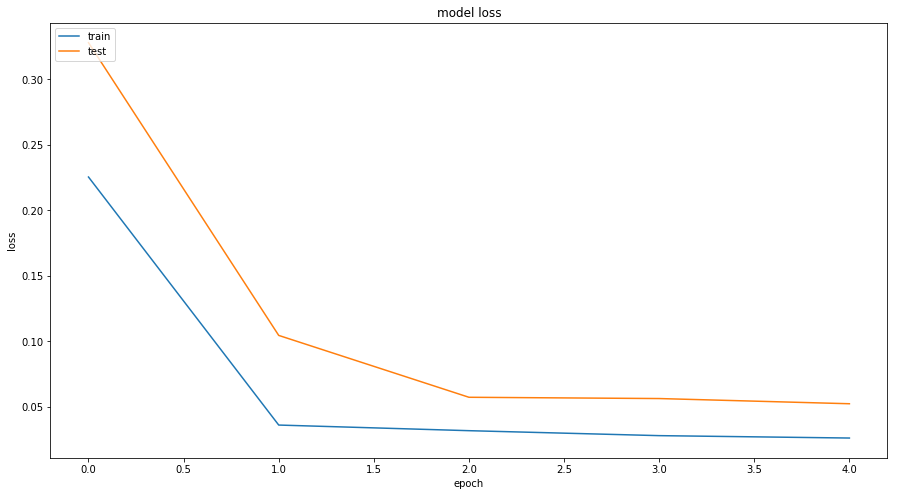

In [36]:
plt.figure(figsize=(15,8))
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Подготовка датасета для вычисления предсказаний моделью

Замечание: 
    
    1) Объекты в поле 'Аппарат перемешивания 2: Нагрузка' по индексу [0:977]  имеют значения равное 0;
    2) Объекты в поле 'Аппарат перемешивания 2: Датчик расхода' по индексу [0:1089] имеют значения равное 0.

In [37]:
df_pred_ = pd.read_excel('Данные для тестового задания 2.xlsx', encoding = 'windows-1251').iloc[:,5:] 

In [38]:
df_pred_.head()

,Аппарат перемешивания 2,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Нагрузка,Датчик расхода,Датчик уровня 1,Датчик уровня 2,Датчик давления
1,0,0,446.4,377.233,-0.01
2,0,0,451.767,377.533,-0.0099
3,0,0,451.933,378,-0.0099
4,0,0,449.567,377.4,-0.00996667


#### Выводы:
    
    1) Вычисление предсказаний из-за отсутствия более 1/3 значений по полю 'Аппарат перемешивания 2: Датчик расхода' осложнено проблемами (вероятено 'Underfitting');
    2) Ошибка модели из-за отсутствия примерно 1/3 значений по полю 'Аппарат перемешивания 2: Нагрузка' будет иметь большие значения.

#### Формирование выборки 

по индексу [1089:], которая состоит из признаков имеющих значения отличные от 0.

In [39]:
df_pred = pd.read_excel('Данные для тестового задания 2.xlsx', encoding = 'windows-1251').iloc[1089:,5:] 

In [40]:
df_pred.rename(columns={'Аппарат перемешивания 2': 'Нагрузка', 
                   'Unnamed: 6': 'Датчик_расхода',
                  'Unnamed: 7': 'Датчик_уровня_1', 
                  'Unnamed: 8': 'Датчик_уровня_2',
                  'Unnamed: 9': 'Датчик_давления'}, inplace=True)

In [41]:
df_pred[df_pred.columns.tolist()] = df_pred[df_pred.columns.tolist()].astype(np.float64)

In [42]:
df_pred.head()

,Нагрузка,Датчик_расхода,Датчик_уровня_1,Датчик_уровня_2,Датчик_давления
1089,9.183333,3.675667,1026.566667,1076.533333,0.155500
1090,9.140000,2.473000,1001.600000,1054.200000,0.172700
1091,9.386667,4.164667,1056.900000,1110.100000,0.168633
1092,9.730000,6.004333,1128.066667,1178.733333,0.162133
1093,9.766667,7.728333,1119.366667,1174.500000,0.199700


In [43]:
X_pred = df_pred.drop(df_pred.columns[0], axis=1)

In [44]:
contin_vars_p = list(X_pred.columns)
contin_maps_p = [([o], StandardScaler()) for o in contin_vars_p]
contin_mapper_p = DataFrameMapper(contin_maps_p)
contin_map_fit_p = contin_mapper_p.fit(X_pred)
contin_cols_p = len(contin_map_fit_p.features)

In [45]:
contin_map_fit_p.transform(X_pred)

array([[-3.253758e+01, -5.087538e-01, -6.376521e-01, -8.635168e+00],
       [-3.585027e+01, -8.815696e-01, -9.584213e-01, -8.228012e+00],
       [-3.119065e+01, -5.579996e-02, -1.555408e-01, -8.324278e+00],
       ...,
       [ 2.007132e-02,  1.228399e+00,  1.293666e+00,  7.672925e-01],
       [ 7.883302e-02,  2.051182e+00,  2.099898e+00,  7.696597e-01],
       [-2.124550e-02,  2.224897e+00,  2.276560e+00,  7.625581e-01]])

In [46]:
def contin_preproc_p(dat):
    return contin_map_fit_p.transform(dat).astype(np.float64)

In [47]:
contin_map_X_pred = contin_preproc_p(X_pred)

In [48]:
contin_map_X_pred

array([[-3.253758e+01, -5.087538e-01, -6.376521e-01, -8.635168e+00],
       [-3.585027e+01, -8.815696e-01, -9.584213e-01, -8.228012e+00],
       [-3.119065e+01, -5.579996e-02, -1.555408e-01, -8.324278e+00],
       ...,
       [ 2.007132e-02,  1.228399e+00,  1.293666e+00,  7.672925e-01],
       [ 7.883302e-02,  2.051182e+00,  2.099898e+00,  7.696597e-01],
       [-2.124550e-02,  2.224897e+00,  2.276560e+00,  7.625581e-01]])

#### Рассчет нагрузки на смешивающий аппарат (предсказания моделью целевой переменной)

In [50]:
preds = np.squeeze(model.predict(contin_map_X_pred))

In [51]:
preds

array([1.      , 1.      , 1.      , ..., 0.901149, 0.942478, 0.948169], dtype=float32)

In [52]:
# функция для инверсии преобразований
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

In [53]:
preds_final = log_max_inv(preds)

In [54]:
preds_final

array([11.366666, 11.366666, 11.366666, ...,  8.938874,  9.883494, 10.021166], dtype=float32)

In [55]:
y_df_pred = df_pred.drop(df_pred.columns[[1, 2, 3, 4]], axis=1)

In [56]:
preds_final = pd.DataFrame(preds_final, index=y_df_pred.index)
preds_final.rename(columns={'0': 'Нагрузка'}, inplace=True)

##### Средняя абсолютная ошибка модели

In [57]:
from sklearn.metrics import mean_absolute_error

In [58]:
print(mean_absolute_error(preds_final, y_df_pred)) 

0.6949178285306608


### График ошибки модели 

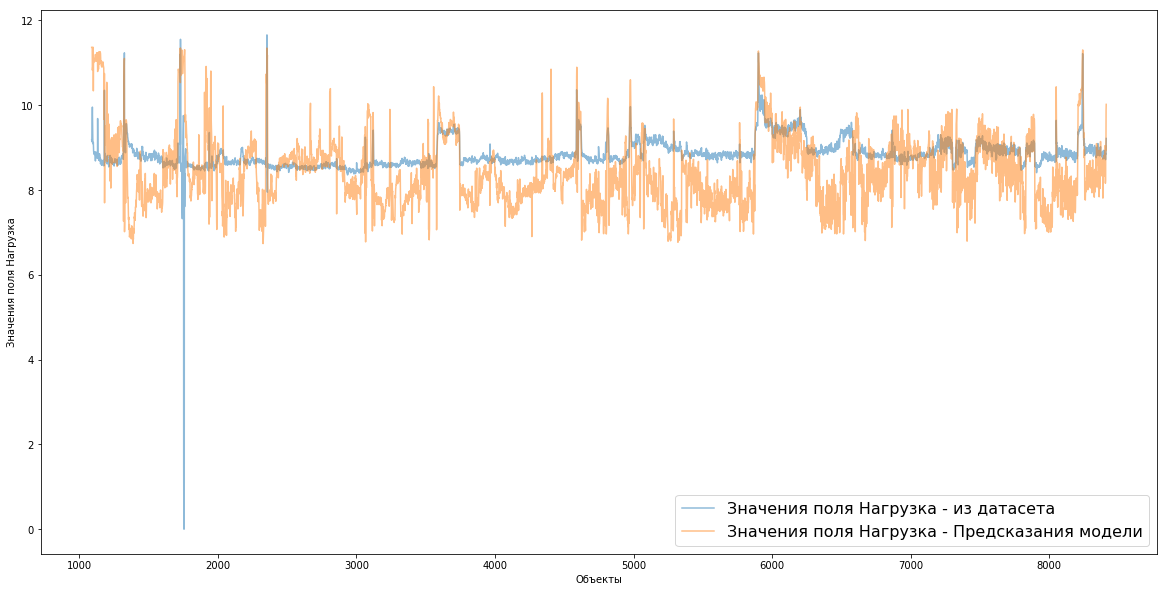

In [63]:
plt.figure(figsize=(20,10))
plt.plot(y_df_pred, alpha=0.5)
plt.plot(preds_final, alpha=0.5)
plt.ylabel('Значения поля Нагрузка')
plt.xlabel('Объекты')
plt.legend(['Значения поля Нагрузка - из датасета', 'Значения поля Нагрузка - Предсказания модели'], 
           loc='best', prop={'size': 16})
plt.show()

## Выводы

    1) Средняя абсолютная ошибка со значением 0.69 является недостаточно минимальной; 
    2) При этом модель в ряде пиков позволила вычислить предсказания с минимальной ошибкой;
    3) Масштабирование признаков по технике 'mean value 0 and standard deviation of 1' ('среднее значение 0 и стандартное отклонение 1') позволяет обучить модель, а обратное преобразование предсказания целевой переменной позволяет получить предсказания по рассчету нагрузки. 
    